In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
import os
os.chdir('..')
sys.path.insert(0, os.getcwd())
import numpy as np

from AE_pipeline_pytorch import (
    LSTMAutoencoder,
    BiLSTMAutoencoder,
    GaitAutoencoder,
    LSTMConvAutoencoder,
    
    GaitBatchIterable,

    train_autoencoder,
    evaluate_and_detect,
    extract_and_save_latents,
    reconstruct_and_evaluate,
    evaluate_autoencoder,
    evaluate_autoencoder_streaming,

    
)

import math
import torch
from time import time
from torch.utils.data import Dataset, DataLoader
import zarr
import torch.backends.cudnn as cudnn

import torch.nn as nn
import torch.optim as optim


2025-07-08 22:07:42.203035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752023262.284656 1524964 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752023262.306967 1524964 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752023262.463153 1524964 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752023262.463186 1524964 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752023262.463189 1524964 computation_placer.cc:177] computation placer alr

Using device: cuda


In [2]:
print(os.getcwd())

/home/dmartinez/Gait-Stability


In [3]:
#Data loader for Zarr datasets
batch_size = 256
train_loader = DataLoader(GaitBatchIterable("train_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)


val_loader = DataLoader(GaitBatchIterable("val_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

test_loader = DataLoader(
    GaitBatchIterable("test_cycles.zarr", batch_size=batch_size, return_meta=True), 
    batch_size=None, 
    num_workers=4,   
    shuffle=False,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)


In [4]:
#To check the data loader
batch = next(iter(train_loader))
for i, item in enumerate(batch):
    print(f"Item {i}: type={type(item)}, shape={getattr(item, 'shape', None)}")

Item 0: type=<class 'torch.Tensor'>, shape=torch.Size([256, 100, 321])
Item 1: type=<class 'torch.Tensor'>, shape=torch.Size([256, 100, 321])


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Entrenamiento con LSTM-Conv
run_id = "Torch11_LSTMCONV_256la"
epochs = 60
model = LSTMConvAutoencoder(input_dim=321, latent_dim=64, n_timesteps=100, dropout=0.4)
train_autoencoder(model, train_loader, val_loader, run_id, epochs)


Epoch 1/60: train_loss=0.6881, val_loss=0.7239


In [6]:
#Train 

model = LSTMAutoencoder(n_timesteps=100, n_vars=321, latent_dim=128).to(device)


# Compila el modelo (PyTorch 2.0 JIT), **antes** de entrenar
#if hasattr(torch, "compile"):
   # model = torch.compile(model)


# Tu función de train_autoencoder acepta train_loader y val_loader
train_autoencoder(
    model,
    train_loader,
    val_loader,
    run_id="Torch10_128la_tanh_60ep_ini_l2_parm",
    epochs=60,
    debug=False,
    debug_batches=60
)

Epoch 1/60: train_loss=0.8730, val_loss=0.8975
Epoch 2/60: train_loss=0.5568, val_loss=0.6045
Epoch 3/60: train_loss=0.4711, val_loss=0.5700
Epoch 4/60: train_loss=0.4510, val_loss=0.5660
Epoch 5/60: train_loss=0.4457, val_loss=0.5371
Epoch 6/60: train_loss=0.4329, val_loss=0.5298
Epoch 7/60: train_loss=0.4256, val_loss=0.5169
Epoch 8/60: train_loss=0.4204, val_loss=0.5123
Epoch 9/60: train_loss=0.4181, val_loss=0.5070
Epoch 10/60: train_loss=0.4085, val_loss=0.5008
Epoch 11/60: train_loss=0.4080, val_loss=0.5055
Epoch 12/60: train_loss=0.4061, val_loss=0.4908
Epoch 13/60: train_loss=0.4006, val_loss=0.4903
Epoch 14/60: train_loss=0.3979, val_loss=0.4878
Epoch 15/60: train_loss=0.3964, val_loss=0.4841
Epoch 16/60: train_loss=0.3956, val_loss=0.4777
Epoch 17/60: train_loss=0.3925, val_loss=0.4791
Epoch 18/60: train_loss=0.3892, val_loss=0.4736
Epoch 19/60: train_loss=0.3898, val_loss=0.4698
Epoch 20/60: train_loss=0.3853, val_loss=0.4738
Epoch 21/60: train_loss=0.3855, val_loss=0.4647
E

Se ha generado el gráfico de pérdidas con los nombres de los modelos en la leyenda y se ha guardado como 'loss_plot_with_model_names.png'.


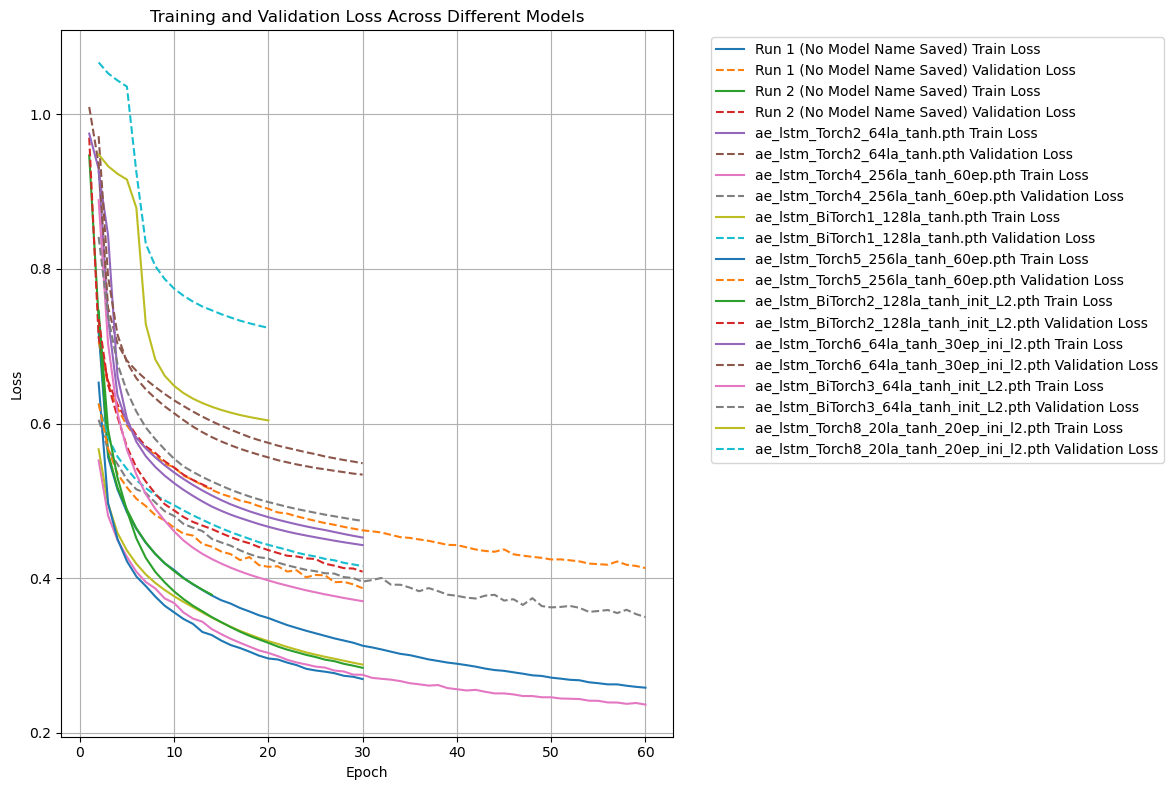

In [ ]:
#Plot results from results.loss file
import matplotlib.pyplot as plt
import re
import pandas as pd

# Read the content of the file
with open('Results loss.txt', 'r') as f:
    lines = f.readlines()

all_runs_info = [] # Will store dictionaries like {'model_name': '...', 'epochs_data': [...]}
current_epochs_data = [] # Data for the current run being parsed
current_model_name = None

for line in lines:
    line = line.strip()
    if line.startswith('Epoch'):
        # If 'Epoch 1/' is encountered and we have data from a previous run,
        # it means a new training run is starting. Save the previous run's data.
        if line.startswith('Epoch 1/') and current_epochs_data:
            # If current_model_name is None, it means the previous run did not have a SAVE line.
            # In this case, we assign a default name.
            if current_model_name is None:
                current_model_name = f"Run {len(all_runs_info) + 1} (No Model Name Saved)"
            all_runs_info.append({'model_name': current_model_name, 'epochs_data': current_epochs_data})
            current_epochs_data = []
            current_model_name = None # Reset for the new run

        # Extract epoch, train_loss, and val_loss
        match = re.search(r'Epoch (\d+)/\d+:\s+train_loss=([\d.]+),\s+val_loss=([\d.]+)', line)
        if match:
            epoch = int(match.group(1))
            train_loss = float(match.group(2))
            val_loss = float(match.group(3))
            current_epochs_data.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss
            })
    elif '[SAVE] Final model' in line:
        # Extract model name from the SAVE line
        match_save = re.search(r'saved_models/(.+?\.pth)', line)
        if match_save:
            current_model_name = match_save.group(1)
        
        # If we have epoch data for the current run, append it along with the model name.
        if current_epochs_data:
            all_runs_info.append({'model_name': current_model_name, 'epochs_data': current_epochs_data})
            current_epochs_data = [] # Reset for the next run
            current_model_name = None # Reset model name

# Handle the case for the very last run if it doesn't end with a [SAVE] line
# or if it's the only run and has no [SAVE] line.
if current_epochs_data:
    if current_model_name is None:
        current_model_name = f"Run {len(all_runs_info) + 1} (No Model Name Saved)"
    all_runs_info.append({'model_name': current_model_name, 'epochs_data': current_epochs_data})

plt.figure(figsize=(12, 8))

# Plot each run's data using the extracted model name for the legend
for run_info in all_runs_info:
    model_name = run_info['model_name']
    epochs_data = run_info['epochs_data']

    if epochs_data: # Ensure epochs_data is not empty before creating a DataFrame
        df = pd.DataFrame(epochs_data)
        plt.plot(df['epoch'], df['train_loss'], label=f'{model_name} Train Loss')
        plt.plot(df['epoch'], df['val_loss'], label=f'{model_name} Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Different Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Position legend outside the plot
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('loss_plot_with_model_names.png') # Save the generated plot with a new filename

print("Se ha generado el gráfico de pérdidas con los nombres de los modelos en la leyenda y se ha guardado como 'loss_plot_with_model_names.png'.")

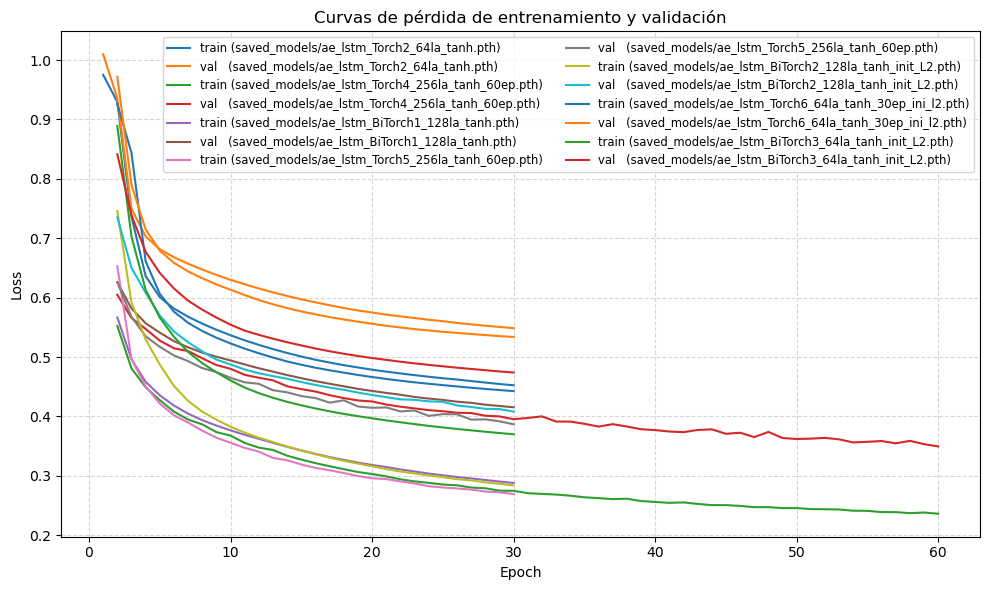

In [ ]:
#Plot results 
import re
import matplotlib.pyplot as plt

# 1) Leer el fichero de logs
with open('loss_results.txt', 'r', encoding='utf-8') as f:
    log_str = f.read()

# 2) Parsear por modelo
parts = re.split(r"\[SAVE\] Final model → ([^\n]+)", log_str)
data = {}
for i in range(1, len(parts), 2):
    model_name = parts[i].strip()
    segment    = parts[i-1]
    matches = re.findall(r"Epoch\s+(\d+)/\d+: train_loss=([\d\.]+), val_loss=([\d\.]+)", segment)
    if matches:
        epochs       = [int(e)       for e, _, _ in matches]
        train_losses = [float(t)     for _, t, _ in matches]
        val_losses   = [float(v)     for _, _, v in matches]
        data[model_name] = {'epoch': epochs, 'train': train_losses, 'val': val_losses}

# 3) Graficar todas las curvas en un único plot
plt.figure(figsize=(10, 6))
for model_name, d in data.items():
    plt.plot(d['epoch'], d['train'], label=f"train ({model_name})")
    plt.plot(d['epoch'], d['val'],   label=f"val   ({model_name})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curvas de pérdida de entrenamiento y validación")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [9]:
#Train backbone
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time


torch.backends.cudnn.benchmark = True

model = GaitAutoencoder(input_channels=321, seq_length=100, latent_dim=20).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.5,     # reduce LR a la mitad
                              patience=3,     # tras 3 épocas sin mejora
                              #verbose=True
)
scaler    = GradScaler()

# Early stopping
best_val_loss   = float('inf')
epochs_no_imp   = 0
early_stop_patience = 5 

num_epochs = 10
for epoch in range(1, num_epochs+1):
    t0 = time.time()
    # ---- Entrenamiento ----
    model.train()
    total_train = 0.0
    for x, _ in train_loader:
        x = x.to(device, dtype=torch.float16)
        optimizer.zero_grad()
        with autocast():
            x_recon, _ = model(x)
            loss = criterion(x_recon, x)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train += loss.item()
    avg_train = total_train / len(train_loader)

    # ---- Validación ----
    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device, dtype=torch.float16)
            with autocast():
                x_recon, _ = model(x)
                total_val += criterion(x_recon, x).item()
    avg_val = total_val / len(val_loader)

    # ---- Scheduler step ----
    # Reduce LR si avg_val no mejora tras 'patience' épocas
    scheduler.step(avg_val)

    # ---- Early stopping check ----
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        epochs_no_imp = 0
        # Guarda el mejor modelo
        torch.save(model.state_dict(), "best_gait_autoencoder.pt")
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= early_stop_patience:
            print(f"--> Early stopping at epoch {epoch}")
            break

    # ---- Logging ----
    epoch_time = time.time() - t0
    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train: {avg_train:.4f}  Val: {avg_val:.4f}  "
          f"Time: {epoch_time:.1f}s  LR: {optimizer.param_groups[0]['lr']:.2e}")

print(f"Mejor val loss: {best_val_loss:.4f}")



/tmp/ipykernel_591534/3465785374.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
/tmp/ipykernel_591534/3465785374.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_591534/3465785374.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10  Train: 0.9347  Val: 0.9699  Time: 210.3s  LR: 1.00e-04


/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/torch/utils/data/dataloader.py:750: UserWarning: Length of IterableDataset <AE_pipeline_pytorch.GaitBatchIterable object at 0x7450711a9330> was reported to be 760(when accessing len(dataloader)), but 761 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)
/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/torch/utils/data/dataloader.py:750: UserWarning: Length of IterableDataset <AE_pipeline_pytorch.GaitBatchIterable object at 0x7450711aa980> was reported to be 165(when accessing len(dataloader)), but 166 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pyt

Epoch 2/10  Train: 0.8246  Val: 0.9521  Time: 226.8s  LR: 1.00e-04
Epoch 3/10  Train: 0.8137  Val: 0.9447  Time: 230.4s  LR: 1.00e-04
Epoch 4/10  Train: 0.8088  Val: 0.9411  Time: 211.3s  LR: 1.00e-04
Epoch 5/10  Train: 0.8054  Val: 0.9372  Time: 220.3s  LR: 1.00e-04
Epoch 6/10  Train: 0.8002  Val: 0.9310  Time: 226.6s  LR: 1.00e-04
Epoch 7/10  Train: 0.7937  Val: 0.9259  Time: 223.5s  LR: 1.00e-04
Epoch 8/10  Train: 0.7896  Val: 0.9230  Time: 219.0s  LR: 1.00e-04
Epoch 9/10  Train: 0.7870  Val: 0.9205  Time: 226.8s  LR: 1.00e-04
Epoch 10/10  Train: 0.7847  Val: 0.9187  Time: 222.8s  LR: 1.00e-04
Mejor val loss: 0.9187


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score

device = torch.device('cpu')
if not torch.cuda.is_available() or device.type == 'cpu':
    torch.Tensor.pin_memory = lambda self: self

In [7]:
#Evaluate metrics 

model = LSTMAutoencoder(n_timesteps=100, n_vars=321, latent_dim=128).to(device)

# Load state dict and remove '_orig_mod.' prefix if present
state_dict = torch.load("saved_models/ae_lstm_Torch1.pth", map_location="cpu")
clean_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(clean_state_dict)

model.eval()

metrics = evaluate_autoencoder_streaming(model, train_loader, device)
print(metrics)



NotImplementedError: Subclasses of Dataset should implement __getitem__.

In [ ]:
model.eval()
mse = torch.nn.MSELoss(reduction='none')

all_scores = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        recon = model(x)                       # (B, T, 321)
        # Si quieres comparar recon vs y, quizá tu función `evaluate_and_detect`
        # espera (x, y) y devuelve errores. Sino:
        # ejemplo de score: media de MSE por variable
        loss = mse(recon, x).mean(dim=(1,2))   # reconstrucción de x vs x
        # o si tu supervisión es recon vs y:
        # loss = mse(recon, y).mean(dim=(1,2))
        all_scores.append(loss.cpu())

all_scores = torch.cat(all_scores)
print("Test MSE (batch-wise):", all_scores.mean().item())
